In [1]:
# coding: utf-8

import xarray as xr
import numpy as np
from glob import glob
import sys
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pickle
import calendar
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib as mpl
import copy

In [2]:
# Opening a dataset just to get the lat/lon of the grid
aux1 = xr.open_dataset('/chinook/marinier/CONUS_2D/CTRL/2000/wrf2d_d01_CTRL_T2_200010-200012.nc', engine='netcdf4') 
#store = '/chinook/cruman/Data/WetSnow'
#auxPlot = f'/{store}/WetSnow_SN_200010-200012.nc'
#auxPlot = xr.open_dataset(auxPlot)
#auxPlot['S_Events'] = (('south_north', 'west_east'), b)
#auxPlot['S_EventsAVG'] = (('south_north', 'west_east'), b/12)

In [3]:
fo = '/chinook/cruman/Data/Near0Events'
# Get the average number of hours near 0
d_array = np.zeros((14,12,1015,1359))
# Year, Month, Lat, Lon
#for m in range(1,13):
#    l.append([])
sim = '_PGW'
#sim = '_CTRL'
t = 0
for i,y in enumerate(range(2000,2014)):
    print(f"Ano {i}")
    for m in range(1,13):
        if y == 2000 and m < 10:
            continue
        if y == 2013 and m > 9:
            continue
        #print(f"Mes: {m}, Ano: {y}")
        # t2m_PGW_2012_11.p
        aux = pickle.load( open(f'{fo}/t2m{sim}_{y}_{m:02d}.p', 'rb'))
        #print(f'{fo}/t2m_{y}_{m:02d}.p')
        d_array[i,m-1] += aux
        t+= 1
        #print(i, m-1)
        #d_array[m-1].append(aux)
    
print(f"Total # of months: {t}")        

Ano 0
Ano 1
Ano 2
Ano 3
Ano 4
Ano 5
Ano 6
Ano 7
Ano 8
Ano 9
Ano 10
Ano 11
Ano 12
Ano 13
Total # of months: 156


In [18]:
# Month 12 yearly total
total_month = np.sum(d_array, axis=0)
# Annual yearly average total of hours
total = np.sum(total_month, axis=0)

In [15]:
total_month.shape

(12, 1015, 1359)

In [19]:
xll, yll = aux1.XLONG.values[0, 0],aux1.XLAT.values[0, 0]
xur, yur = aux1.XLONG.values[-1, -1],aux1.XLAT.values[-1, -1]

In [27]:
np.max(aux1['total_hour'].values)

2803.9166666666665

In [20]:
# Check this again, It probably should be divided by 13 not 12
aux1['total_day'] = (('south_north', 'west_east'), total/13/24)
aux1['total_hour'] = (('south_north', 'west_east'), total/13)

In [21]:
for i in range(0,12):
    aux1[f'total_month_{i:02d}'] = (('south_north', 'west_east'), total_month[i,:,:]/13)

<ipython-input-22-7155bd1e1dae>:32: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9, extend="both")


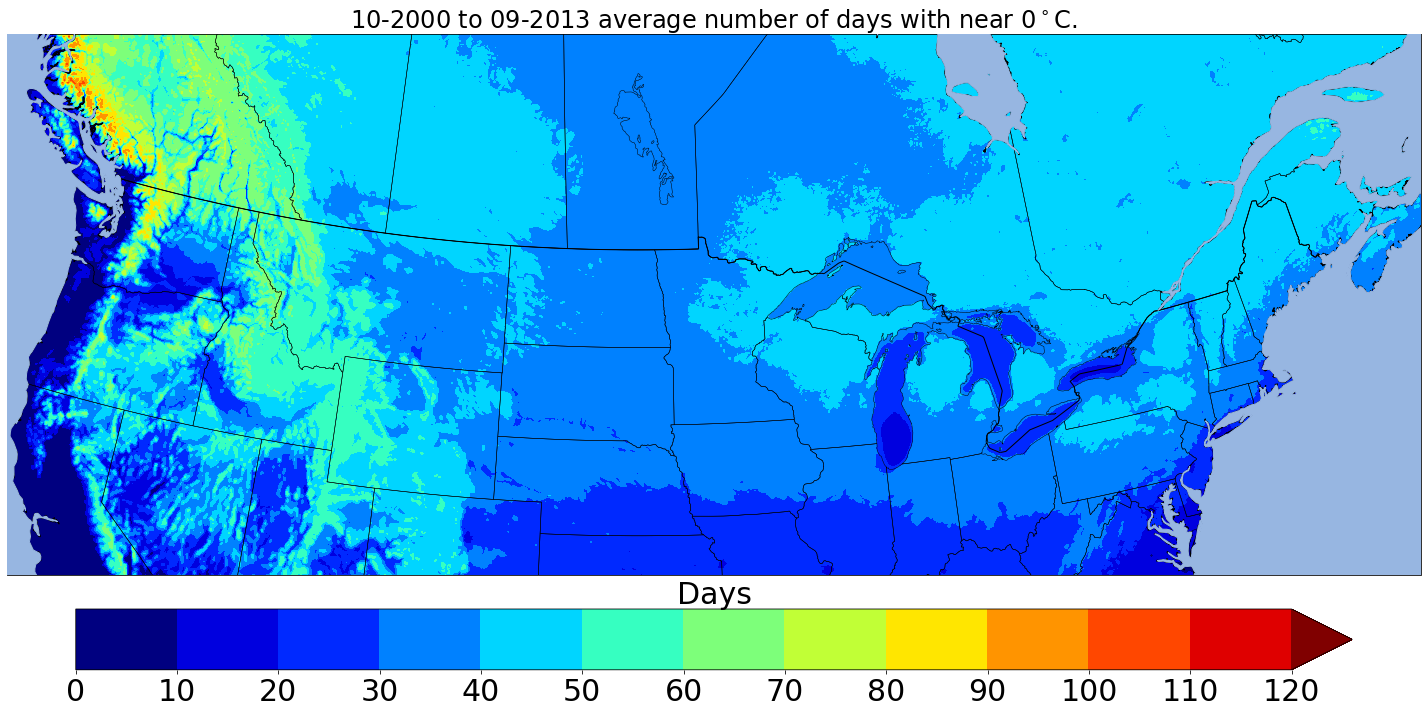

In [22]:
# Plotting Monthly Events
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
new_cmap = 'viridis_r'
new_cmap = mpl.cm.get_cmap("viridis_r")
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 120 #np.max(aux1['total_day'].values)
val_min = 0
val_int = 10
new_cmap = plt.cm.jet
unit = "Days"
title = r"PGW - 10-2000 to 09-2013 average number of days with near 0${\rm ^\circ C}$"

ax.set_extent([xll, xur-10, 36, yur])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)
# Plot figure
cs = aux1['total_day'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max, extend='max')
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9, extend="both")
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='10m', linewidth=width)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
ax.add_feature(cfeature.OCEAN, zorder=10)

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig(f'near_zero_days_v2{sim}.png')
#plt.show()

<ipython-input-23-caf46b6b05eb>:32: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9, extend="both")


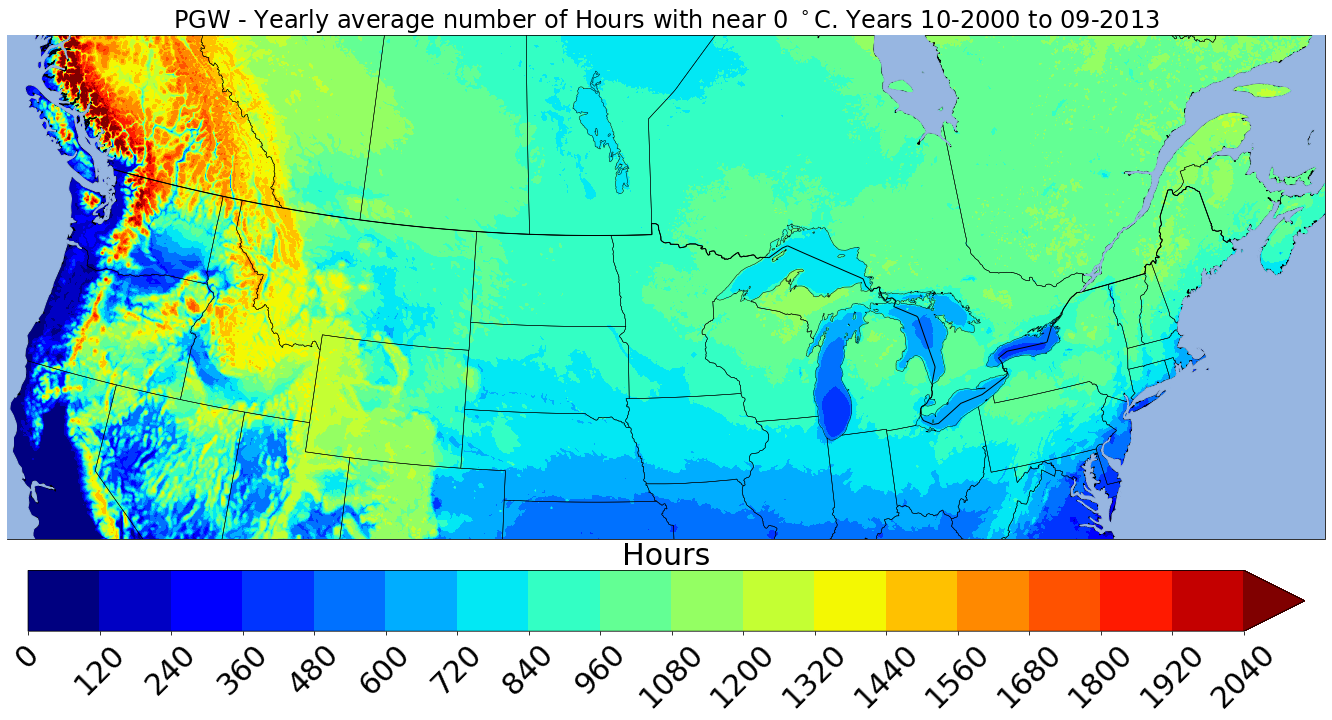

In [23]:
# Plotting Monthly Events
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
new_cmap = 'viridis_r'
new_cmap = mpl.cm.get_cmap("viridis_r")
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 2040 #np.max(aux1['total_day'].values)
val_min = 0
val_int = 120
new_cmap = plt.cm.jet
unit = "Hours"
title = r"PGW - Yearly average number of Hours with near 0 ${\rm ^\circ C}$. Years 10-2000 to 09-2013"

ax.set_extent([xll, xur-10, 36, yur])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)
# Plot figure
cs = aux1['total_hour'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max, extend='max')
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9, extend="both")
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30, labelrotation=45) 
# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='10m', linewidth=width)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
ax.add_feature(cfeature.OCEAN, zorder=10)

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig(f'near_zero_hours{sim}_v2.png')
#plt.show()

<ipython-input-24-e85823ff32b2>:44: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = f.colorbar(cs, cax=cbar_ax, ticks=color_ticks, orientation='horizontal',pad=0.05,shrink=0.9, extend="both")
<ipython-input-24-e85823ff32b2>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


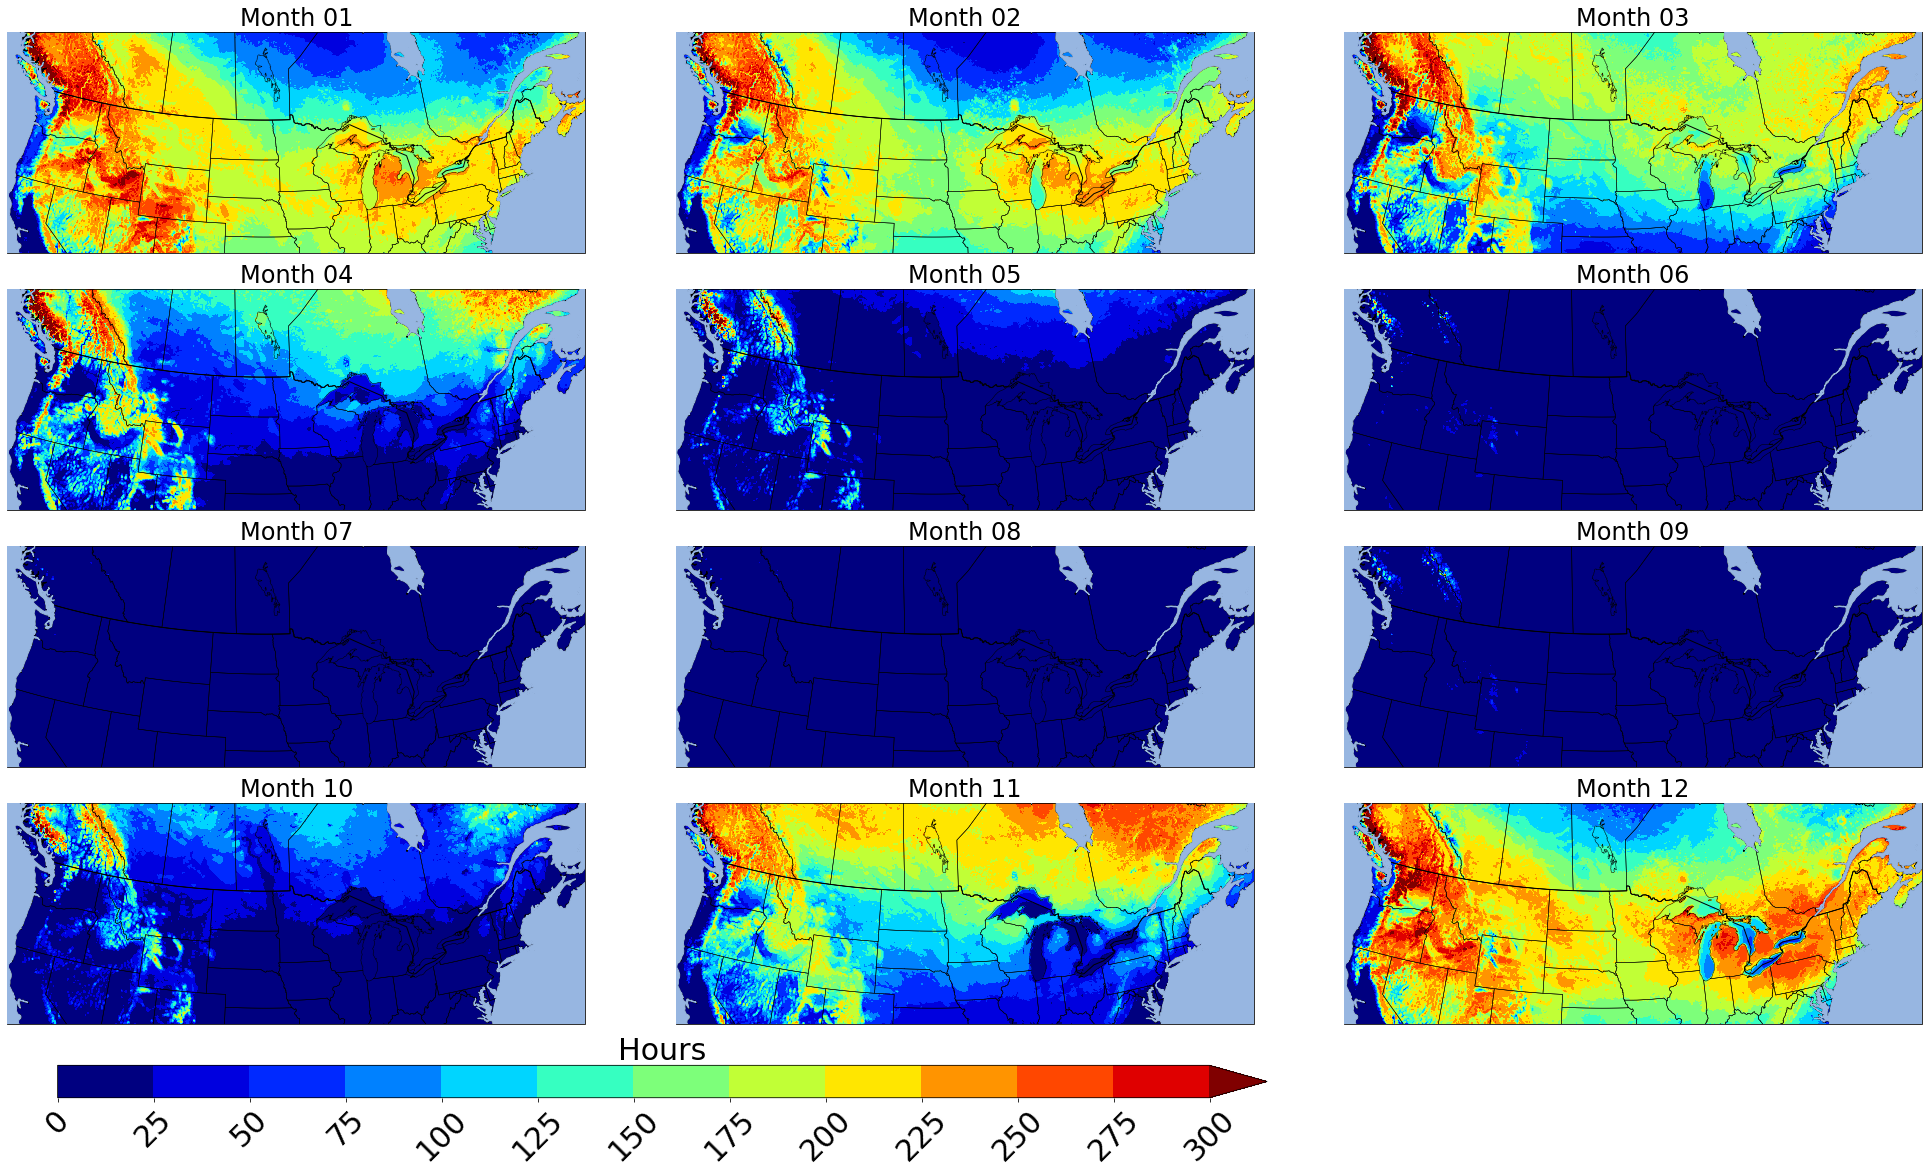

In [24]:
# Plotting Monthly Events
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, axs = plt.subplots(5, 3, figsize=(28, 18), subplot_kw={'projection': myLambert})

width = 1.0  
new_cmap = 'viridis_r'
new_cmap = mpl.cm.get_cmap("viridis_r")
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 300 #np.max(aux1['total_day'].values)
val_min = 0
val_int = 25
new_cmap = plt.cm.jet
unit = "Hours"
title = r"PGW - Average monthly number of Hour with near 0 ${\rm ^\circ C}$. 10-2000 to 09-2013"

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)

for i, ax in enumerate(axs.flat):
    if i > 11:
        f.delaxes(ax)
        continue
    ax.set_extent([xll, xur-10, 36, yur])

# Plot figure
    cs = aux1[f'total_month_{i:02d}'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
               add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max, extend='max')
    
    ax.coastlines(resolution='10m', linewidth=width)
    ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
    ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
    ax.add_feature(cfeature.OCEAN, zorder=10)
    ax.set_title(f"Month {i+1:02d}", fontsize=24)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cbar_ax = f.add_axes([0.05, 0.15, 0.6, 0.025])
cb = f.colorbar(cs, cax=cbar_ax, ticks=color_ticks, orientation='horizontal',pad=0.05,shrink=0.9, extend="both")
#cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9, extend="both")
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30, labelrotation=45) 
# Plot title

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig(f'near_zero_hours_monthly{sim}_v2.png')
#plt.show()

In [ ]:
# Plotting Monthly Events
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, axs = plt.subplots(5, 3, figsize=(14, 20), subplot_kw={'projection': myLambert})

width = 1.0  
new_cmap = 'viridis_r'
#new_cmap = mpl.cm.get_cmap("viridis_r")
new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
new_cmap.set_bad(color='white')

for i, ax in enumerate(axs.flat):        
    #ax.set_extent([-69.5, -63.5, 45, 48.2])
    if i >= 12:
        f.delaxes(ax)
        continue
        
    # Masking values == 0
    im = auxPlot[f'PR_Events{i+1:02d}'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
               add_colorbar=False, cmap=new_cmap, levels=7, vmin=0, vmax=6, extend='max')

    ax.coastlines(resolution='10m', linewidth=width)
    ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
    ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
    ax.add_feature(cfeature.OCEAN, zorder=10)

    ax.set_title(f"Month: {i+1:02d}", fontsize=20)


plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
cb.set_label('Number of Events', size=36)
cbar_ax.tick_params(labelsize=30) 

plt.savefig('PRevents_plot_avg_monthly.png')
#plt.show()